# Автоэнкодеры изображений

Цель проекта - вручную реализовать несколько архитектур автоэнкодеров изображений и познакомиться с основными трюками при их обучении.

# Часть 1. Vanilla Autoencoder

## 1.1. Подготовка данных

Импорты.

In [1]:
import numpy as np
import pandas as pd

from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import os
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean

import copy
from copy import deepcopy

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Попробуем добиться воспроизводимости.

In [2]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

random_seed = 2077
seed_everything(random_seed)

Для многократных запусков пригодится вот такая функция.

In [3]:
def clear_GPU():
    gc.collect()
    torch.cuda.empty_cache()

Так как датасет небольшой и нам нужны только лица (не фон), напишем функцию, которая загружает сразу весь датасет в оперативку.

In [4]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

Посмотрим на шейпы датасета, в частности, поищем канал цветов.

In [5]:
data, attrs = fetch_dataset()
data.shape, attrs.shape

((13143, 64, 64, 3), (13143, 73))

Разбиваем выборки на трейн и валид. Тестовая выборка здесь не нужна.

In [6]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data.astype('float32'), attrs,
                                                                    train_size=0.9, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

Посмотрим глазами на фото после обрезки.

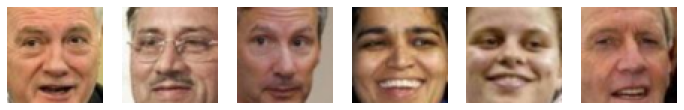

In [7]:
fig = plt.figure(figsize=(12,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(train_photos[i])
    plt.axis('off')

Видим, что на фоото очень мало фона.

Из минусов - все лица повернуты по-разному, наклонены, смотрят вбок и т.д.

## 1.2. Архитектура модели
В этом разделе мы напишем и обучем обычный автоэнкодер.

<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">

Реализуем автоэнкодер в виде класса.

Самое сложно тут - декодер. Используем ConvTranspose2d для повышения разрешения карт признаков.

Из документации:
```
The output spatial dimensions of nn.ConvTranspose2d are given by:

out = (x - 1)s - 2p + d(k - 1) + op + 1

where 
- x - input spatial dimension and out the corresponding output size, 
- s - stride, 
- d - dilation, 
- p - padding, 
- k - kernel size,
- op - output padding
```

Реализуем структуру а-ля резнет.

In [8]:
class basic_block(nn.Module):
    def __init__(self, in_dim, out_dim, **kwargs):
        
        super(basic_block, self).__init__()
        
        # act_layer = nn.LeakyReLU
        act_layer = nn.ReLU
        
        self.two_conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, **kwargs),
            nn.BatchNorm2d(out_dim),
            act_layer(inplace=True),
            nn.Conv2d(out_dim, out_dim, **kwargs),
            nn.BatchNorm2d(out_dim),
        )
        
        self.skip_conv = nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=1, padding=0)
        self.skip_bn = nn.BatchNorm2d(out_dim)
        
    def forward(self, x0):
        x = self.two_conv(x0)
        y = self.skip_bn(self.skip_conv(x0))
        
        return F.relu(x + y)

Декодер пусть состоит из простых и сердитых блоков.

In [9]:
class decoder_block(nn.Module):
    def __init__(self, in_dim, out_dim, kernel=3, bn=True, drop=0, 
                  stride=2, padding=1, dilation=1, output_padding=1, **kwargs):
        
        super(decoder_block, self).__init__()
        
        # act_layer = nn.LeakyReLU
        act_layer = nn.ReLU
        
        self.upConv = nn.ConvTranspose2d(
            in_dim, out_dim, kernel_size=kernel, stride=stride, 
            padding=padding, dilation=dilation, output_padding=output_padding)
        
        self.two_conv = nn.Sequential(
            nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            act_layer(inplace=True),
            nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            act_layer(inplace=True),
            nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
        )
        
        self.skip_conv = nn.Conv2d(out_dim, out_dim, kernel_size=1, stride=1, padding=0)
        self.skip_bn = nn.BatchNorm2d(out_dim)
        
    def forward(self, x0):
        x0 = self.upConv(x0)
        x = self.two_conv(x0)
        y = self.skip_bn(self.skip_conv(x0))
        
        return F.relu(x + y)

А теперь построим модели из блоков.

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, first_dim=16, bn=True, drop_encoder=0, drop_decoder=0):
        super().__init__()
        
        first_dim = 16
        
        self.encoder = nn.Sequential()
        self.encoder.add_module('preparation',
            nn.Conv2d(3, first_dim, kernel_size=1, stride=1, padding=0))
        
        for i in range(6):
            self.encoder.add_module(str(i)+'_conv_1',
                basic_block(
                    first_dim*(2**i), 
                    first_dim*(2**(i+1)), 
                    kernel_size=3, stride=1, padding=1)
            )
            self.encoder.add_module(str(i)+'_maxpool', nn.MaxPool2d(2))
            
        latent_dim = first_dim*(2**(5+1))
        self.decoder = nn.Sequential()
        for i in range(1,7):
            in_dim = round(latent_dim/(2**(i-1)))
            out_dim = round(latent_dim/(2**(i)))
            self.decoder.add_module(str(i),
                decoder_block(in_dim, 
                              out_dim, 
                              stride=2, kernel=3, bn=bn, drop=drop_decoder)
            )

        self.decoder.add_module('to_3_colors',
            nn.Conv2d(out_dim,
                     3,
                     kernel_size=1, stride=1, padding=0))
        self.decoder.add_module('sigmoid', nn.Sigmoid())
        
    def encode(self, sample):
        sample = sample.permute(0,3,1,2)
        sample = sample - 0.5
        latent = self.encoder(sample)
        return latent.squeeze()
        
    def decode(self, latent):
        latent = latent[:,:,None,None]
        reconstructed = self.decoder(latent)
        reconstructed = reconstructed.permute(0,2,3,1)
        return reconstructed
        
    def forward(self, sample):
        latent = self.encode(sample)
        return self.decode(latent), latent

Посмотрим на шейпы, которые выдает модель.

In [11]:
autoencoder = Autoencoder(first_dim=32)

for a in train_loader:
    print('input shape:', a.shape)
    #print(a.dtype)
    lat = autoencoder.encode(a)
    print('\nnlatent shape:', lat.shape)
    print('\nreconstructed shape:', autoencoder.decode(lat).shape)
    break

input shape: torch.Size([32, 64, 64, 3])

nlatent shape: torch.Size([32, 1024])

reconstructed shape: torch.Size([32, 64, 64, 3])


## 1.3 Обучение

Напишем несколько функций для обучения.

In [12]:
def plot_train_curves(history, name='', best_min=True):
    train_loss, val_loss, train_metr, val_metr, lr = history['train_loss'], history['val_loss'], history['train_metr'], history['val_metr'], history['lr'], 
    fig = plt.figure(figsize=(6,8))
    fig.patch.set_facecolor('xkcd:white')
    plt.subplot(3,1,1)
    points = np.array(train_loss + val_loss, dtype=float)
    points = points[~np.isnan(points)]
    points = points[np.isfinite(points)]
    p = 0.08
    q1, q2 = np.nanquantile(points, p), np.nanquantile(points, 1-p)
    iqr = q2 - q1
    lim1 = max(np.nanmin(points) - iqr * 0.06, q1 - iqr * 1.2)
    lim2 = min(np.nanmax(points) + iqr * 0.06, q2 + iqr * 1.2)
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend()
    plt.ylim(lim1, lim2)
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.subplot(3,1,2)
    plt.plot(train_metr, label="train_metr")
    plt.plot(val_metr, label="val_metr")
    if best_min:
        my = np.array(val_metr).min()
        mx = np.argmin(np.array(val_metr))
    else:
        my = np.array(val_metr).max()
        mx = np.argmax(np.array(val_metr))
    plt.scatter(x=[mx], y=[my], c='red', s=80)
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("metric")

    plt.subplot(3,1,3)
    plt.plot(lr, label="LR")
    plt.xlabel("epochs")
    plt.ylabel("LR")
    plt.yscale('log')
    
    if len(name) > 0:
        plt.suptitle(name)
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.savefig(name+'.png')
    plt.show()

После каждой эпохи будем смотреть глазами на результат на валидации.

In [13]:
def show_val_pics(history, pics_real, pics_reconst, name, epoch, epochs, best_metr, num=6):
    idx = np.random.choice(pics_real.shape[0], num, replace=False)
    fig = plt.figure(figsize=(10,5))
    for k in range(num):
        n = idx[k]
        image_original = pics_real[n]
        image_reconst = pics_reconst[n]
        plt.subplot(2, num, k+1)
        plt.imshow(image_original, cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, num, k+num+1)
        plt.imshow(image_reconst, cmap='gray')
        plt.title('Reconstruct')
        plt.axis('off')

    train_m = history['train_metr'][-1]
    val_m = history['val_metr'][-1]

    plt.suptitle(
                f'{name}   Epoch: {epoch+1}/{epochs}   train metric: {train_m:.4f}   valid metric: {val_m:.4f}   [best metric {best_metr:.4f}]'
                        )        
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.show()

А вот главная функция - прогон одной эпохи. Тут же стоит "аугментация" датасета.

In [14]:
def single_epoch(model, optimizer, loss_fn, data_loader, metric, mode='val'):
    
    noise_factor = 0.1
    
    torch.set_grad_enabled(mode == 'train')
    if mode == 'train':
        model.train()
    else:
        model.eval()
    
    avg_loss = 0
    model.train()  # train mode
    pics_real = [] # real data
    pics_reconst = [] # reconstructed data
    losses = []
    for X_batch in data_loader:
        if mode == 'train':
            tr = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=.1, hue=.01),
                transforms.RandomAdjustSharpness(sharpness_factor=1),
                # transforms.RandomAutocontrast(p=0.5)
            ])
            X_batch = tr(X_batch.permute(0,3,1,2)).permute(0,2,3,1)
            
        pics_real.append(X_batch.detach().numpy())
        
        if mode == 'train':
            X_batch_noise = X_batch + torch.randn_like(X_batch) * noise_factor
            X_batch_noise = X_batch_noise.to(device)
            optimizer.zero_grad()
        
        X_batch = X_batch.to(device)
        
        if mode == 'train':
            reconst, latent = model(X_batch_noise)
        else:
            reconst, latent = model(X_batch)
            
        pics_reconst.append(reconst.cpu().detach().numpy())
        loss = loss_fn(reconst, X_batch)
        if mode == 'train':
            loss.backward()
            optimizer.step()
            
        losses.append(loss.cpu().detach().item())

    pics_real = np.concatenate(pics_real, axis=0)
    pics_reconst = np.concatenate(pics_reconst, axis=0)
    epoch_loss = np.array(losses).mean()
    epoch_metr = metric(pics_reconst.flatten(), pics_real.flatten()).mean()
    
    torch.set_grad_enabled(True)
    model.eval()
    
    return pics_real, pics_reconst, epoch_loss, epoch_metr

In [15]:
def train_ae(model, optimizer, loss_fn, epochs, data_tr, data_val, metric, 
          scheduler=None, plots=True, set_best_params=True, name=''):
    
    best_metr = None
    best_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = dict(
        train_loss = [],
        val_loss = [],
        train_metr = [],
        val_metr = [],
        lr = []
    )

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}, best = {best_epoch}')
        history['lr'].append(optimizer.param_groups[0]["lr"])
        
        # training
        train_res = single_epoch(model, optimizer, loss_fn, data_tr, metric, mode='train')
        history['train_loss'].append(train_res[2])
        history['train_metr'].append(train_res[3])

        # validating
        val_res = single_epoch(model, optimizer, loss_fn, data_val, metric, mode='val')
        pics_real = val_res[0]
        pics_reconst = val_res[1]
        history['val_loss'].append(val_res[2])
        history['val_metr'].append(val_res[3])   
        
        # is best epoch ???
        if best_metr == None: best_metr = history['val_metr'][-1]
        if history['val_metr'][-1] < best_metr:
            print('new best val metric!')
            best_epoch = epoch + 1
            best_metr = history['val_metr'][-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            # torch.save(model, 'H:/2022_DL_Stepik/models' + f'{val_f1:.4}' + '.pt')

        if scheduler != None: scheduler.step(history['val_loss'][-1])

        # visualize
        clear_output(wait=True)
        if plots:
            show_val_pics(history, pics_real, pics_reconst, name, epoch, epochs, best_metr, num=6)

            if epoch > 1:
                plot_train_curves(history, name)
    
    if set_best_params:
        model.load_state_dict(best_model_wts)
        print(f'Weights loaded from best epoch {best_epoch}, metric = {best_metr:0.4f}')
            
    return(history)

А теперь обучение.

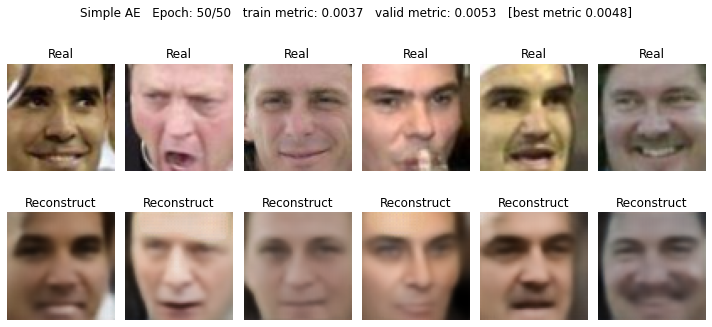

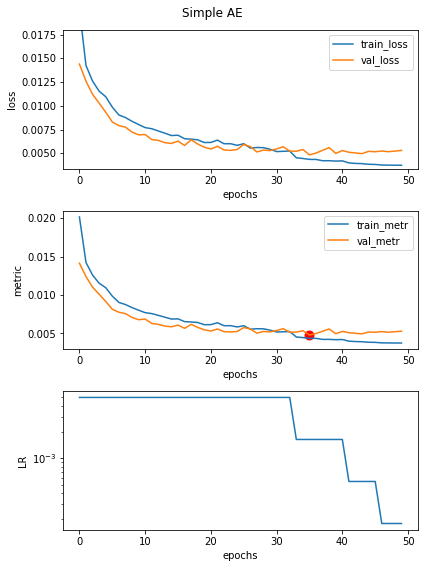

Weights loaded from best epoch 36, metric = 0.0048
CPU times: total: 47min 6s
Wall time: 47min 9s


In [16]:
%%time
criterion = nn.MSELoss()
autoencoder = Autoencoder(512, drop_encoder=0, drop_decoder=0)
autoencoder.to(device)
metr = lambda x,y: mean_squared_error(x, y)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=5e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.33, patience=4)

h = train_ae(model=autoencoder, optimizer=optimizer, loss_fn=criterion, 
             epochs=50, data_tr=train_loader, data_val=val_loader, metric=metr, 
             scheduler=scheduler, plots=True, set_best_params=True, name='Simple AE')

Посмотрим, как тренированный автоэекодер кодирует и восстанавливает картинки.

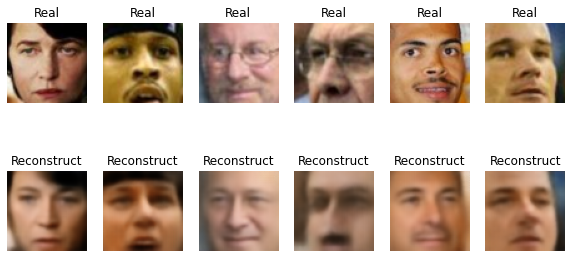

In [17]:
val_loader_small = torch.utils.data.DataLoader(val_photos, batch_size=32, shuffle=True)

for a in val_loader_small:
    autoencoder.eval()
    with torch.no_grad():
        original = a.detach().numpy()
        rec, lat = autoencoder(a.to(device))
        rec = rec.cpu().detach().numpy()
        lat = lat.cpu().detach().numpy()
    break

l = min(rec.shape[0], 6)
fig = plt.figure(figsize=(10,5))
for i in range(l):
    plt.subplot(2, l, i+1)
    plt.imshow(original[i], cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, l, i+l+1)
    plt.imshow(rec[i], cmap='gray')
    plt.title('Reconstruct')
    plt.axis('off')

Неплохо для такой простенькой модели.

## 1.4. Sampling

А теперь нагенерируем случайных векторов и запустим их на вход декодера.

Но для начала надо понять, где эти случайные вектора могут лежать. Для этого найдем статистические характеристики распределения эмбеддингов всей валидационной выборки.

In [18]:
lat_mean = lat.mean(axis=0)
lat_std = lat.var(axis=0)

А теперь генерируем и смотрим.

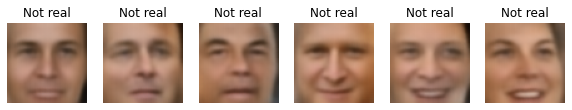

In [62]:
num = 6
z = np.random.randn(num, lat_mean.shape[0]) * lat_std * 1.3 + lat_mean
z = torch.FloatTensor(z).to(device)
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decode(z)
output = output.cpu().detach().numpy()

l = output.shape[0]
fig = plt.figure(figsize=(10,5))
for i in range(l):
    plt.subplot(1, l, i+1)
    plt.imshow(output[i], cmap='gray')
    plt.title('Not real')
    plt.axis('off')

Даже похоже на лица!

## Изменение фич лица

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько людей с улыбками и столько же без.

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Прогоним весь датасет через модель, найдем латентные вектора для всех фото.

In [20]:
full_loader = torch.utils.data.DataLoader(
    data.astype('float32'), batch_size=32, shuffle=False)

autoencoder.eval()
latent_repres = []

with torch.no_grad():
    for X_batch in full_loader:
        r, l = autoencoder(X_batch.to(device))
        l = l.cpu().detach().numpy()
        latent_repres.append(l)

In [21]:
latent_repres = np.concatenate(latent_repres, axis=0)

Не будем мелочиться и посчитаем вектора не только для улыбки, но и вообще для всех фичей лиц.

In [22]:
feature_list = list(attrs.columns)
# feature_list

In [23]:
max_num = 15
feature_vec = {}
for feature in feature_list:
    tmp = attrs.sort_values(feature, ascending=False)

    idx = list(tmp.head(max_num).index)
    top_vec = latent_repres[idx,:].mean(axis=0)
    
    idx = list(tmp.tail(max_num).index)
    bottom_vec = latent_repres[idx,:].mean(axis=0)
    
    v = top_vec - bottom_vec
    feature_vec[feature] = v

Напишем функцию для варьирования одной фичи на одной картинке.

In [24]:
def vary_feature(idx, feature, max_k=0.5):
    num_faces = 9
    autoencoder.eval()
    in_tensor = torch.Tensor(data.astype('float32')[idx])
    fig = plt.figure(figsize=(num_faces*1.3,3.5))
    plt.subplot(2, num_faces, round(num_faces/2+0.5))
    plt.imshow(in_tensor.numpy(), cmap='gray')
    plt.axis('off')
    with torch.no_grad():
        l_zero = autoencoder.encode(in_tensor.unsqueeze(0).to(device))
        for i, k in enumerate(np.linspace(-max_k, max_k, num_faces)):
            diff_vec = torch.Tensor(feature_vec[feature]) * k
            diff_vec = diff_vec.to(device)
            #diff_vec = 1
            l = l_zero + diff_vec
            r = autoencoder.decode(l.unsqueeze(0))
            plt.subplot(2, num_faces, num_faces+1+i)
            plt.imshow(r.cpu().numpy().squeeze(), cmap='gray')
            if k == 0:
                plt.title('Reconstruct')
            else:
                plt.title(feature + '\n' + str(round(k, 1)))
            plt.axis('off')
            
    plt.suptitle('Varying \"' + feature + '\" feature')
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.show()

Запустим эту функцию на каком-нибудь лице для нескольких фичей.

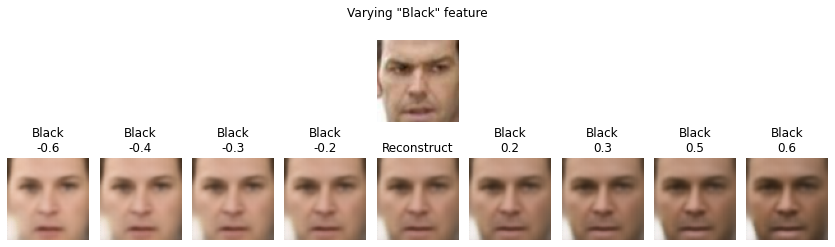

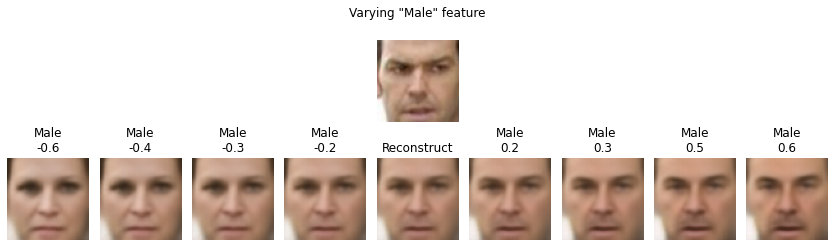

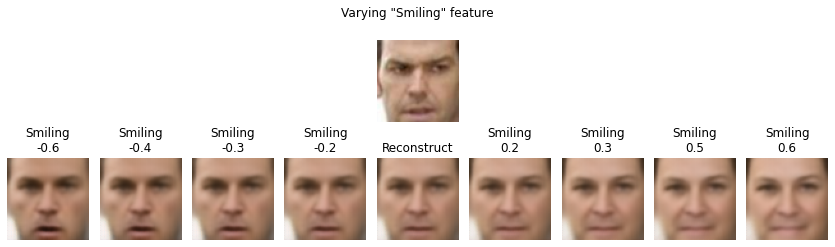

In [25]:
for feature in ['Black', 'Male', 'Smiling']:
    vary_feature(1123, feature, max_k=0.6)

Работает!

## Image Retrieval

Давайте представим, что весь наш тренировочный датасет - это большая база данных людей. И вот мы получили картинку лица какого-то человека и хотим понять, что это за человек. Что нам делать? Правильно - берем наш автоэнкодер, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

- Получаем латентные представления всех лиц
- Обучаем на них KNeighborsClassifier
- Берем произвольную картинку, получаем ее латентный вектор
- Ищем с помощью обученного KNeighborsClassifier ближайшие из латентных представлений в базе
- Находим лица , которым соответствуют ближайшие латентные представления, визуализируем

In [26]:
neighbors = KNeighborsClassifier()
neighbors.fit(latent_repres, [0]*latent_repres.shape[0]);

In [27]:
def get_similar(num, n_neighbors=5):
    l = latent_repres[num,:]
    dist, idx = neighbors.kneighbors(l[None,:], n_neighbors + 1)
    dist, idx = dist.squeeze()[1:], idx.squeeze()[1:]
    
    plt.figure(figsize=(12,5.5))
    
    img = data[num]
    plt.subplot(2, n_neighbors, n_neighbors//2+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original image')
    
    for i in range(n_neighbors):
        plt.subplot(2, n_neighbors, n_neighbors+i+1)
        n = idx[i]
        
        d = dist[i]
        img = data[n]
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Distance\n{d}')

    return dist.squeeze()[1:], idx.squeeze()[1:]

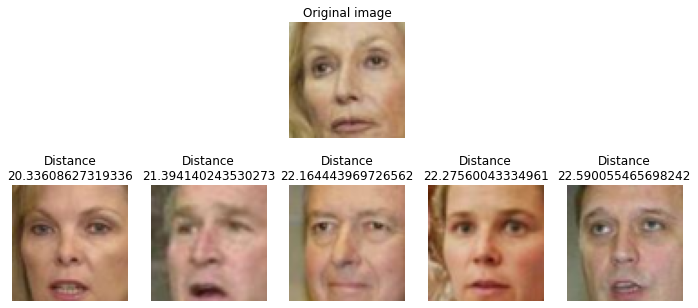

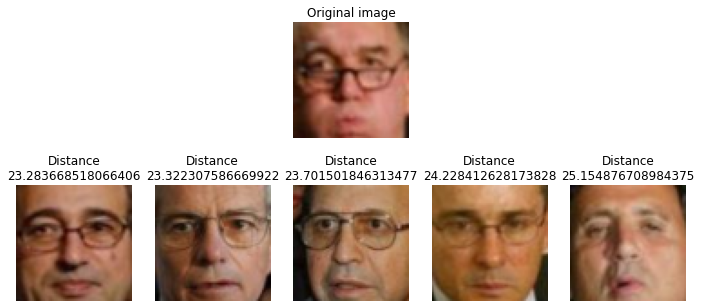

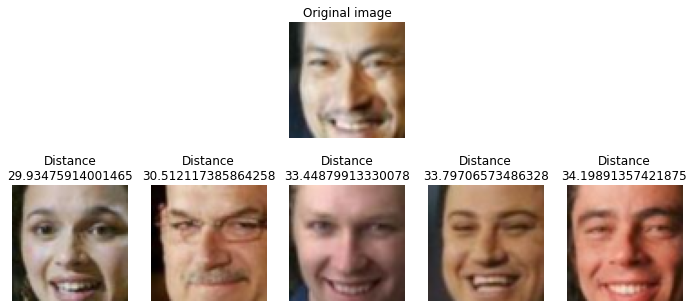

In [28]:
for i in np.random.choice(np.arange(len(data)), 3, replace=False):
    get_similar(i);

Реально похожи! Правда, я бы сказал, что похожи не лицом, а некими мета-фичами типа наличия улыбки, ориентации головы, цвета кожи и т.д.

# Часть 2: Variational Autoencoder

Для ускорения расчетов будем заниматься VAE на датасете MNIST с монохромными цифрами.

In [29]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader_mnist = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader_mnist = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Посмотрим, как распределены каналы в одной картинке.

In [30]:
test_dataset[0][0].shape

torch.Size([1, 28, 28])

## 2.1 Архитектура модели и обучение

Реализуем VAE. Так как датасет "простенький", то и модель будет несложная. Заметим, что количество каналов почти во всех слоях одинаково (а не увеличивается по мере углубления внутрь модели).

In [31]:
class VAE(nn.Module):
    def __init__(self, lat_dim=64):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, lat_dim, kernel_size=3, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.Conv2d(lat_dim, lat_dim, kernel_size=3, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.Conv2d(lat_dim, lat_dim, kernel_size=3, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.Conv2d(lat_dim, lat_dim*2, kernel_size=3, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim*2),
            nn.Conv2d(lat_dim*2, lat_dim*2, kernel_size=2, stride=1),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(lat_dim, lat_dim, kernel_size=4, dilation=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.ConvTranspose2d(lat_dim, lat_dim, kernel_size=4, dilation=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.ConvTranspose2d(lat_dim, lat_dim, kernel_size=4, dilation=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.ConvTranspose2d(lat_dim, lat_dim, kernel_size=3, dilation=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.ConvTranspose2d(lat_dim, lat_dim, kernel_size=3, dilation=1, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.Conv2d(lat_dim, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = x - 0.5
        x = self.encoder(x)
        x = x.squeeze().view(x.shape[0], 2, -1)
        mu = x[:,0,:]
        log_var = x[:,1,:]
        return mu, log_var
    
    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            random_part = torch.randn_like(std)
            sample = mu + std * random_part
        else:
            sample = mu
        return sample
    
    def decode(self, z):
        z = z[:,:,None,None]
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, log_var = self.encode(x)
        sample = self.gaussian_sampler(mu, log_var)
        #log_var = log_var[:,:,None,None]
        reconstruction = self.decode(sample)
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, log_var, reconstruction

Как обычно, проверим работу модели по шейпам.

In [32]:
sample_batch = 0
for x_batch, y_batch in train_loader_mnist:
    sample_batch = x_batch
    break
sample_batch.shape

torch.Size([32, 1, 28, 28])

In [33]:
vae = VAE()
r = vae(sample_batch)
r[0].shape, r[1].shape, r[2].shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([32, 1, 28, 28]))

Определим лосс и его компоненты для VAE:

Лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

Для начала посмотрим, как отличаются значения функций потерь MSE и log-likelihood на картах уровней.

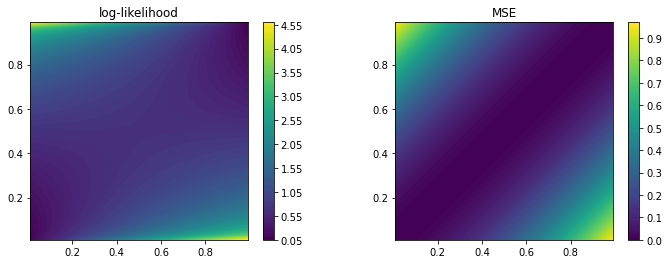

In [34]:
x = np.linspace(0.01, 0.99, 50)
y = np.linspace(0.01, 0.99, 50)
xx, yy = np.meshgrid(x, y)

zz_log = - (xx * np.log(yy)) - ((1 - xx) * np.log(1 - yy))
zz_mse = (xx - yy)**2

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
h = plt.contourf(x, y, zz_log, levels=100)
plt.axis('scaled')
plt.colorbar()
plt.title('log-likelihood')

plt.subplot(1,2,2)
h = plt.contourf(x, y, zz_mse, levels=100)
plt.axis('scaled')
plt.colorbar()
plt.title('MSE')

plt.show()

MSE симметрична относительно диагонали, а log-likelihood - нет.

[Интересное видео на эту тему](https://www.youtube.com/watch?v=ywYuZrLENH0)

In [35]:
def KL_divergence(mu, log_var):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return loss

def MSE_loss(x, reconstruction):
    loss = nn.MSELoss(reduction='sum')
    return loss(reconstruction, x)

def log_loss(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, log_var, reconstruction):
    loss1 = KL_divergence(mu, log_var)
    # loss2 = MSE_loss(x, reconstruction)
    loss2 = log_loss(x, reconstruction)
    return loss1 + loss2

И обучим модель.

Тут ради интереса добавим еще шум на картинку. Чтобы было веселее.

In [36]:
def single_epoch(model, optimizer, loss_fn, data_loader, metric, mode='val'):
    
    noise_factor = 0.15
    
    torch.set_grad_enabled(mode == 'train')
    if mode == 'train':
        model.train()
    else:
        model.eval()
    
    avg_loss = 0
    model.train()  # train mode
    pics_real = [] # real data
    pics_reconst = [] # reconstructed data
    losses = []
    for X_batch, Y_batch in data_loader:
        pics_real.append(X_batch.detach().numpy())
        
        if mode == 'train':
            X_batch_noise = X_batch + torch.randn_like(X_batch) * noise_factor
            X_batch_noise = X_batch_noise.to(device)
            optimizer.zero_grad()
            
        X_batch = X_batch.to(device)

        if mode == 'train':
            mu, log_var, reconstruction = model(X_batch_noise)
        else:
            mu, log_var, reconstruction = model(X_batch)
            
        pics_reconst.append(reconstruction.cpu().detach().numpy())
        loss = loss_fn(X_batch, mu, log_var, reconstruction)
        if mode == 'train':
            loss.backward()
            optimizer.step()
            
        losses.append(loss.cpu().detach().item())

    pics_real = np.concatenate(pics_real, axis=0)
    pics_reconst = np.concatenate(pics_reconst, axis=0)
    epoch_loss = np.array(losses).mean()
    epoch_metr = metric(pics_reconst.flatten(), pics_real.flatten()).mean()
    
    torch.set_grad_enabled(True)
    model.eval()
    
    return pics_real, pics_reconst, epoch_loss, epoch_metr

In [37]:
def show_val_pics(history, pics_real, pics_reconst, name, epoch, epochs, best_metr, num=6):
    idx = np.random.choice(pics_real.shape[0], num, replace=False)
    fig = plt.figure(figsize=(10,5))
    for k in range(num):
        n = idx[k]
        image_original = pics_real[n].transpose(1,2,0)
        image_reconst = pics_reconst[n].transpose(1,2,0)
        
        plt.subplot(2, num, k+1)
        plt.imshow(image_original, cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, num, k+num+1)
        plt.imshow(image_reconst, cmap='gray')
        plt.title('Reconstruct')
        plt.axis('off')

    train_m = history['train_metr'][-1]
    val_m = history['val_metr'][-1]

    plt.suptitle(
                f'{name}   Epoch: {epoch+1}/{epochs}   train metric: {train_m:.4f}   valid metric: {val_m:.4f}   [best metric {best_metr:.4f}]'
                        )        
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.show()

Запускаем обучение. Специально возьмем не слишком большое латентное пространство, чтобы потом можно было быстро сделать TSNE.

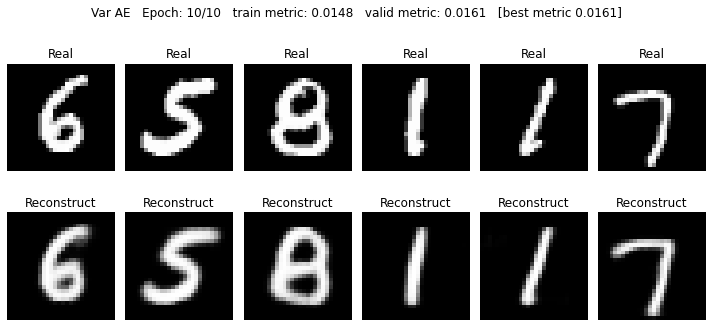

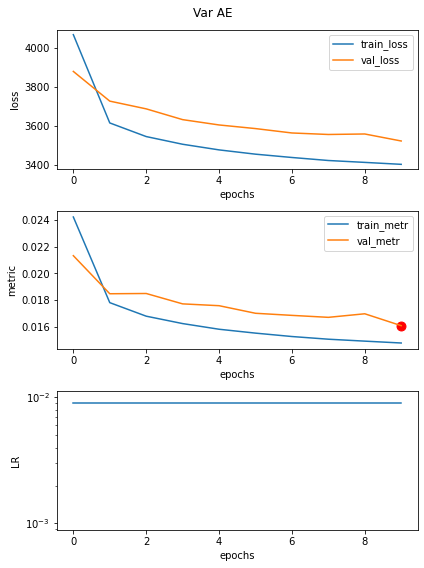

Weights loaded from best epoch 10, metric = 0.0161
CPU times: total: 3min 34s
Wall time: 4min 2s


In [38]:
%%time
criterion = loss_vae
vae = VAE(lat_dim=16)
vae.to(device)

metr = lambda x,y: mean_squared_error(x, y)

optimizer = torch.optim.AdamW(vae.parameters(), lr=9e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.33, patience=2)

h = train_ae(model=vae, optimizer=optimizer, loss_fn=criterion, 
             epochs=10, data_tr=train_loader_mnist, data_val=val_loader_mnist, metric=metr, 
             scheduler=scheduler, plots=True, set_best_params=True, name='Var AE')

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

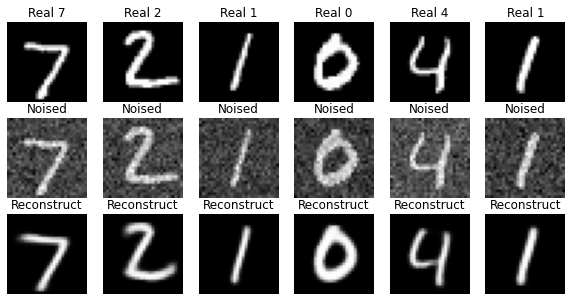

In [39]:
mus = []
log_vars = []
pics_originals = []
pics_noised = []
pics_rec = []

noise_factor = 0.15
vae.eval()
with torch.no_grad():
    for X_batch, Y_batch in val_loader_mnist:
        X_batch_noised = X_batch + torch.randn_like(X_batch) * noise_factor

        original = X_batch.detach().numpy().transpose(0,2,3,1)
        noised = X_batch_noised.detach().numpy().transpose(0,2,3,1)
        mu, log_var, rec = vae(X_batch_noised.to(device))
        rec = rec.cpu().detach().numpy().transpose(0,2,3,1)
        
        mus.append(mu.cpu().detach().numpy())
        log_vars.append(log_var.cpu().detach().numpy())
        pics_originals.append(original)
        pics_noised.append(noised)
        pics_rec.append(rec)

mus = np.concatenate(mus, axis=0)
log_vars = np.concatenate(log_vars, axis=0)
pics_originals = np.concatenate(pics_originals, axis=0)
pics_noised = np.concatenate(pics_noised, axis=0)
pics_rec = np.concatenate(pics_rec, axis=0)
labels = test_dataset.targets.numpy()
    
l = min(rec.shape[0], 6)
fig = plt.figure(figsize=(10,5))
for i in range(l):
    plt.subplot(3, l, i+1)
    plt.imshow(pics_originals[i], cmap='gray')
    plt.title('Real ' + str(labels[i]))
    plt.axis('off')
    
    plt.subplot(3, l, i+l+1)
    plt.imshow(pics_noised[i], cmap='gray')
    plt.title('Noised')
    plt.axis('off')

    plt.subplot(3, l, i+2*l+1)
    plt.imshow(pics_rec[i], cmap='gray')
    plt.title('Reconstruct')
    plt.axis('off')

Вообще отлично!

А теперь небольшое "исследование": какие статистики у распределений всех компонент латентных векторов? Нормально ли они распределены?

Сначала средние значения.

In [40]:
a = pd.DataFrame(mus)
a.describe().T

,count,mean,std,min,25%,50%,75%,max
0,10000.0,-0.039809,1.016154,-4.612603,-0.647913,0.006221,0.604616,3.381555
1,10000.0,-0.224293,1.023982,-3.288419,-0.923926,-0.264545,0.495232,3.098470
2,10000.0,-0.018676,0.989293,-2.875611,-0.708945,-0.080916,0.583327,3.427174
3,10000.0,-0.011398,0.960329,-3.435879,-0.638010,-0.036841,0.653570,3.911798
4,10000.0,-0.079612,1.080377,-3.163813,-0.797833,-0.003266,0.715385,2.633281
5,10000.0,-0.067543,0.988026,-3.389600,-0.718304,-0.048585,0.584913,4.296310
6,10000.0,0.083743,1.152898,-3.426520,-0.666272,0.103922,0.859073,2.609264
7,10000.0,-0.096091,1.050247,-3.130866,-0.898731,-0.121995,0.635029,2.781758
8,10000.0,0.032000,0.971323,-4.189132,-0.561579,0.059024,0.640650,3.752650
9,10000.0,0.078911,0.947695,-3.313441,-0.548300,0.072908,0.701943,3.782843


В целом распределения средних значений похожи на нормальные.

Теперь стандартные отклонения.

In [41]:
a = pd.DataFrame(np.exp(0.5 * log_vars))
a.describe().T

,count,mean,std,min,25%,50%,75%,max
0,10000.0,0.287481,0.063196,0.155469,0.237537,0.274363,0.335228,0.487721
1,10000.0,0.206191,0.049747,0.127571,0.175397,0.192301,0.216698,0.412686
2,10000.0,0.175983,0.040825,0.112293,0.149947,0.165164,0.186513,0.361094
3,10000.0,0.422505,0.120015,0.209482,0.340966,0.390845,0.468420,0.874575
4,10000.0,0.133813,0.022887,0.083335,0.115861,0.130489,0.147862,0.239401
5,10000.0,0.308178,0.098528,0.176836,0.256276,0.280286,0.309710,0.773199
6,10000.0,0.098475,0.026053,0.064367,0.081536,0.091563,0.105435,0.244111
7,10000.0,0.136164,0.027369,0.098374,0.118973,0.128695,0.141534,0.269103
8,10000.0,0.416308,0.111664,0.234106,0.339753,0.384625,0.457421,0.863418
9,10000.0,0.324474,0.074517,0.179720,0.274625,0.309877,0.352181,0.651647


А вот тут все сложнее - разброс сильный, то есть наше "облако" латентных векторов "не круглое".

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются.

Здесь опыт показывает, что лучше подсовывать обычное нормальное распределение, не скорректированное на среднее значение выборки.

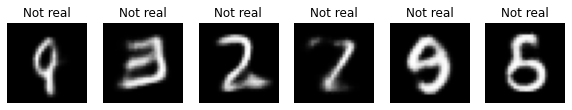

In [42]:
mu_base = mus.mean(axis=0)
log_var_base = log_vars.mean(axis=0)

std = 1
# std = torch.exp(0.5 * torch.Tensor(log_var_base)) * 1
z = torch.randn(6, mu_base.shape[0]) * std + torch.Tensor(mu_base)
z.to(device)

vae.eval()
with torch.no_grad():
    rec = vae.decode(z.to(device))
    rec = rec.cpu().detach().numpy().transpose(0,2,3,1)

l = min(rec.shape[0], 6)
fig = plt.figure(figsize=(10,5))
for i in range(l):
    plt.subplot(1, l, i+1)
    plt.imshow(rec[i], cmap='gray')
    plt.title('Not real')
    plt.axis('off')

В целом похоже на рецепт лекарства от врача...

## 2.2. Latent Representation

Посмотрим, как латентные векторы картинок лиц выглядят в двумерном пространстве. Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

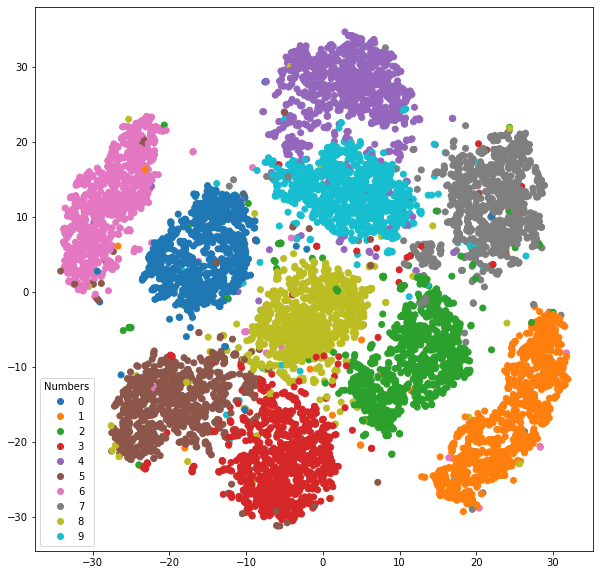

In [43]:
t_sne = TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=50,
    early_exaggeration=14,
    n_iter=500,
    init="random",
    random_state=2077,
)

mus_2d = t_sne.fit_transform(mus)

plt.figure(figsize=(10,10))

scatter = plt.scatter(x=mus_2d[:,0], 
            y=mus_2d[:,1], 
            c=labels,
            cmap='tab10'
           )
plt.legend(handles=scatter.legend_elements()[0],
           labels=[str(i) for i in range(10)],
           title="Numbers");

- точки явно группируются в облака, соответствующие цифрам
- четверка и девятка опасно смешаны

## 2.3. Conditional VAE

Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).

Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного - это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [44]:
class CVAE(nn.Module):
    def __init__(self, lat_dim=64, num_classes=10):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, lat_dim, kernel_size=3, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.Conv2d(lat_dim, lat_dim, kernel_size=3, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.Conv2d(lat_dim, lat_dim, kernel_size=3, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.Conv2d(lat_dim, lat_dim*2, kernel_size=3, stride=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim*2),
            nn.Conv2d(lat_dim*2, lat_dim*2, kernel_size=2, stride=1),
        )
        
        lat_dim = lat_dim + num_classes
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(lat_dim, lat_dim, kernel_size=4, dilation=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.ConvTranspose2d(lat_dim, lat_dim, kernel_size=4, dilation=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.ConvTranspose2d(lat_dim, lat_dim, kernel_size=4, dilation=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.ConvTranspose2d(lat_dim, lat_dim, kernel_size=3, dilation=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.ConvTranspose2d(lat_dim, lat_dim, kernel_size=3, dilation=1, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(lat_dim),
            nn.Conv2d(lat_dim, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        x = x - 0.5
        x = self.encoder(x)
        x = x.squeeze().view(x.shape[0], 2, -1)
        mu = x[:,0,:]
        log_var = x[:,1,:]
        return mu, log_var, class_num
        
    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            random_part = torch.randn_like(std)
            sample = mu + std * random_part
        else:
            sample = mu
        return sample
    
    def decode(self, z, class_num):
        ohe = F.one_hot(class_num, num_classes=10)
        z = torch.concat([z, ohe], axis=1)
        z = z[:,:,None,None]
        reconstruction = self.decoder(z)
        return reconstruction
        
        return reconstruction

    def forward(self, x, class_num):
        mu, log_var, _ = self.encode(x, class_num)
        sample = self.gaussian_sampler(mu, log_var)
        #log_var = log_var[:,:,None,None]
        reconstruction = self.decode(sample, class_num)
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, log_var, reconstruction

Проверка размерностей.

In [45]:
sample_batch = 0
for x_batch, y_batch in train_loader_mnist:
    sample_x_batch = x_batch
    sample_y_batch = y_batch
    break
sample_x_batch.shape, sample_y_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [46]:
cvae = CVAE()
r = cvae(sample_x_batch, sample_y_batch)
r[0].shape, r[1].shape, r[2].shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([32, 1, 28, 28]))

Перепишем обучение эпохи под новую модель.

In [47]:
def single_epoch(model, optimizer, loss_fn, data_loader, metric, mode='val'):
    
    noise_factor = 0.25
    
    torch.set_grad_enabled(mode == 'train')
    if mode == 'train':
        model.train()
    else:
        model.eval()
    
    avg_loss = 0
    model.train()  # train mode
    pics_real = [] # real data
    pics_reconst = [] # reconstructed data
    losses = []
    for X_batch, Y_batch in data_loader:
        pics_real.append(X_batch.detach().numpy())
        
        if mode == 'train':
            X_batch_noise = X_batch + torch.randn_like(X_batch) * noise_factor
            X_batch_noise = X_batch_noise.to(device)
            optimizer.zero_grad()
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        if mode == 'train':
            mu, log_var, reconstruction = model(X_batch_noise, Y_batch)
        else:
            mu, log_var, reconstruction = model(X_batch, Y_batch)

        pics_reconst.append(reconstruction.cpu().detach().numpy())
        loss = loss_fn(X_batch, mu, log_var, reconstruction)
        if mode == 'train':
            loss.backward()
            optimizer.step()
            
        losses.append(loss.cpu().detach().item())

    pics_real = np.concatenate(pics_real, axis=0)
    pics_reconst = np.concatenate(pics_reconst, axis=0)
    epoch_loss = np.array(losses).mean()
    epoch_metr = metric(pics_reconst.flatten(), pics_real.flatten()).mean()
    
    torch.set_grad_enabled(True)
    model.eval()
    
    return pics_real, pics_reconst, epoch_loss, epoch_metr

MSE лосс работает лучше, чем BCE.

In [48]:
def loss_vae(x, mu, log_var, reconstruction):
    loss1 = KL_divergence(mu, log_var)
    loss2 = MSE_loss(x, reconstruction)
    return loss1 + loss2

Обучаем.

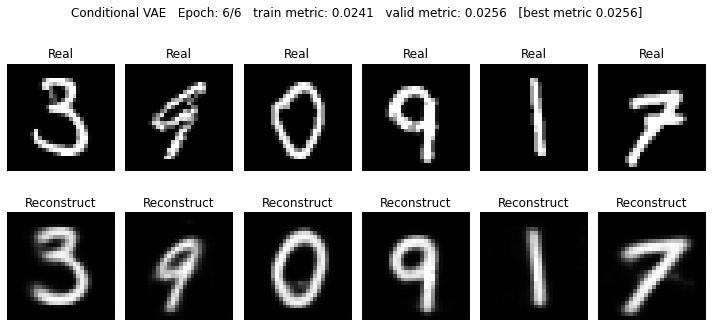

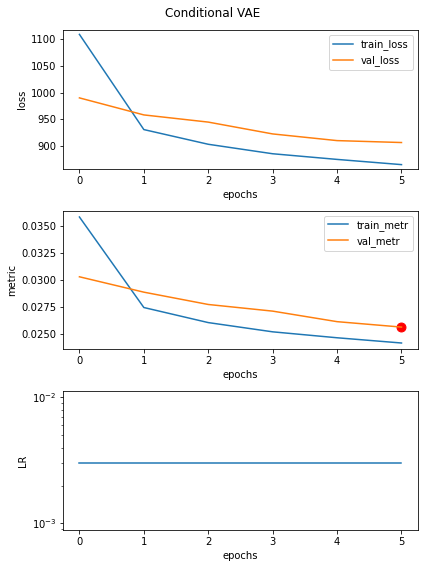

Weights loaded from best epoch 6, metric = 0.0256
CPU times: total: 2min 20s
Wall time: 2min 56s


In [49]:
%%time
criterion = loss_vae
cvae = CVAE(lat_dim=16)
cvae.to(device)

metr = lambda x,y: mean_squared_error(x, y)

optimizer = torch.optim.AdamW(cvae.parameters(), lr=3e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.33, patience=2)

h = train_ae(model=cvae, optimizer=optimizer, loss_fn=criterion, 
             epochs=6, data_tr=train_loader_mnist, data_val=val_loader_mnist, metric=metr, 
             scheduler=scheduler, plots=True, set_best_params=True, name='Conditional VAE')

### Sampling


Попробуем брать один и тот же латентный вектор и восстановить из него картинки разных классов.

Каждая строка - это один латентный вектор, а каждый столбец - это один класс.

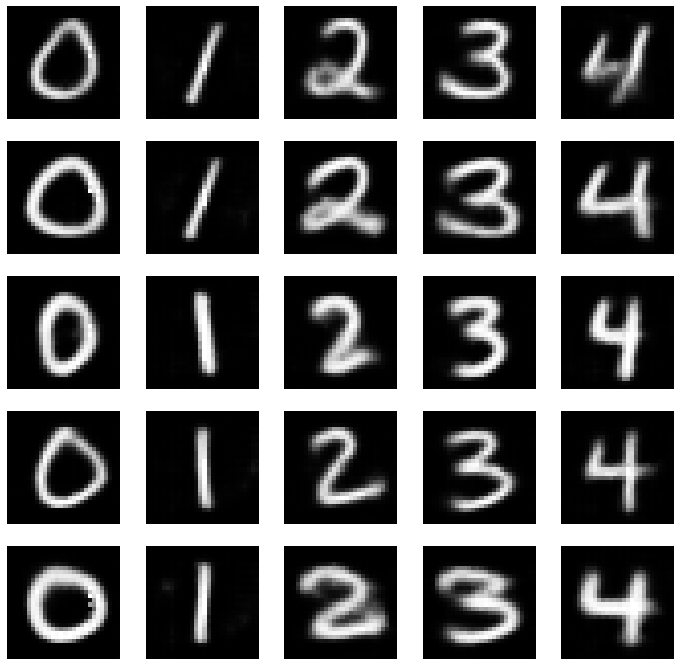

In [59]:
fig = plt.figure(figsize=(12,12))
cvae.eval()

cols = 5
rows = 5
for i in range(cols):
    z = torch.randn(1,16) * 0.9
    z = z.to(device)
    for c in range(rows):
        v = torch.LongTensor([c])
        v = v.to(device)
        with torch.no_grad():
            img = cvae.decode(z, v)
        img = img.cpu().numpy().squeeze()
        plt.subplot(rows, cols, 1 + i * rows + c)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

Выглядит очень по-человечески!

### Latent Representations

Посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE.

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [51]:
mus = []

cvae.eval()
with torch.no_grad():
    for X_batch, Y_batch in val_loader_mnist:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        mu, log_var, rec = cvae(X_batch, Y_batch)
        mus.append(mu.cpu().detach().numpy())
        
mus = np.concatenate(mus, axis=0)

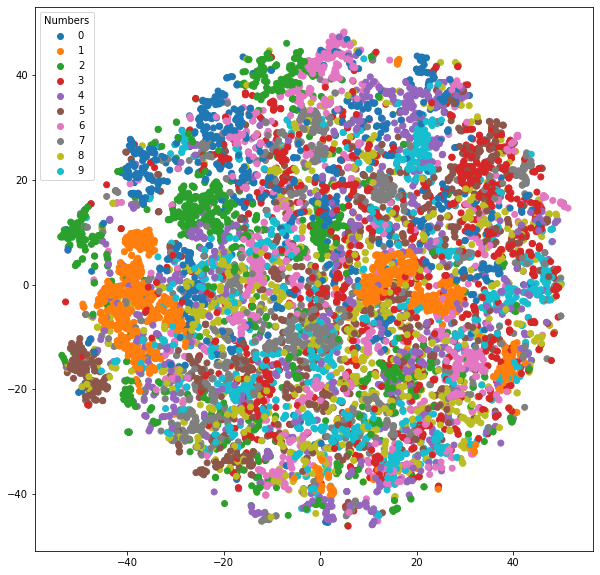

In [52]:
t_sne = TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=50,
    n_iter=500,
    init="random",
    random_state=2077,
)

mus_2d = t_sne.fit_transform(mus)
labels = test_dataset.targets.numpy()

plt.figure(figsize=(10,10))

scatter = plt.scatter(x=mus_2d[:,0], 
            y=mus_2d[:,1], 
            c=labels,
            cmap='tab10'
           )
plt.legend(handles=scatter.legend_elements()[0],
           labels=[str(i) for i in range(10)],
           title="Numbers");

Латентные вектора не разделяются, да им и не надо - за них это делает переменная класса.

# Выводы

Реализованы:
- обычный автоэнкодер на лицах
    - сэмплинг случайных векторов из латентного пространства
    - определение векторов "фич" лиц, например, улыбок
    - модификация фич на фотографиях
    - Image Retrieval - поиск лиц в датасете, похожих на какое-то одно лицо
- вариационный автоэнкодер на MNIST
    - denoising
    - лосс как сумма BCELoss и KL divergence
    - сэмплинг случайных векторов из латентного пространства
    - модификация: conditional VAE